# Explore Daymet climate data around Clear Lake Reservoir. 

## We will be using the OPeNDAP (Open-source Project for a Network Data Access Protocol) endpoint and xarray to access the "Daily Surface Weather Data on a 1-km Grid for North America, Version 3" data product

## Research questions: Knowing Tucker fire began on July 29, 2019,
## 1) How was August 1, 2019 air temperature look like in the Clear Lake Reservoir region? 
## 2) How was the average air temperature around the reservoir region on August 1, 2019 compared to the average air temperature around the reservoir region on August 1 in the past 10-year (2009-2018)?

### THREDDS Data Server catalog page for this product
### OPeNDAP endpoint url: 
### https://thredds.daac.ornl.gov/thredds-daymet/dodsC/daymet-v3-agg/na.ncml (xarray can directly read from this url)

## This is based on Tuesday Tutorial 2 and 3

In [1]:
# To get started, import xarray and other libraries we'll be using in this notebook...

import xarray as xr

# for working with geospatial data
import geopandas as gpd
from pyproj import CRS
from shapely import geometry

# for plotting, import matplotlib.pyplot
import matplotlib.pyplot as plt
# tell jupyter to display plots "inline" in the notebook
%matplotlib inline

## Use xarray to open the dataset at this OPeNDAP endpoint

In [4]:
# Open DayMet Dataset
ds = xr.open_dataset("https://thredds.daac.ornl.gov/thredds-daymet/dodsC/daymet-v3-agg/na.ncml")
ds

<xarray.Dataset>
Dimensions:                  (nv: 2, time: 14600, x: 7814, y: 8075)
Coordinates:
  * x                        (x) float32 -4560250.0 -4559250.0 ... 3252750.0
  * y                        (y) float32 4984000.0 4983000.0 ... -3090000.0
  * time                     (time) datetime64[ns] 1980-01-01 ... 2019-12-31
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
Dimensions without coordinates: nv
Data variables:
    lambert_conformal_conic  int16 ...
    yearday                  (time) int16 ...
    time_bnds                (time, nv) datetime64[ns] ...
    dayl                     (time, y, x) float32 ...
    prcp                     (time, y, x) float32 ...
    srad                     (time, y, x) float32 ...
    swe                      (time, y, x) float32 ...
    tmax                     (time, y, x) float32 ...
    tmin                     (time, y, x) float32 ...
    vp                       (time, y, x) float32 ...
Attributes:
    start_year:        1980
    source:            Daymet Software Version 3.0
    Version_software:  Daymet Software Version 3.0
    Version_data:      Daymet Data Version 3.0
    Conventions:       CF-1.6
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...
    title:             Daymet: Daily Surface Weather Data on a 1-km Grid for ...
    institution:       Oak Ridge National Laboratory Distributed Active Archi...
    end_year:          2019

In [5]:
# Get the coordinate reference system used by DayMet
daymet_crs = CRS.from_cf(ds.lambert_conformal_conic.attrs)

## Make our Clear Lake Reservoir bounding box and use it to subset the DayMet dataset:

In [7]:
# Specify the region we want to look at with DayMet (lon_min, lat_min, lon_max, lat_max)
# and the coordinate system we are providing the bounding box coordinates in (epsg:4326)
# finally, reproject our bounding box polygon into this new coordinate system (Lambert Conformal Conic)
bounding_box = gpd.GeoSeries(geometry.box(-121.27, 41.92, -121.09, 41.82), crs='epsg:4326').to_crs(daymet_crs)

# Select this region from our DayMet Dataset
clearLake = ds.sel(x = slice(bounding_box.bounds.minx[0], bounding_box.bounds.maxx[0]),
                 y = slice(bounding_box.bounds.maxy[0], bounding_box.bounds.miny[0]))

In [8]:
clearLake

<xarray.Dataset>
Dimensions:                  (nv: 2, time: 14600, x: 17, y: 13)
Coordinates:
  * x                        (x) float32 -1667250.0 -1666250.0 ... -1651250.0
  * y                        (y) float32 151000.0 150000.0 ... 140000.0 139000.0
  * time                     (time) datetime64[ns] 1980-01-01 ... 2019-12-31
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
Dimensions without coordinates: nv
Data variables:
    lambert_conformal_conic  int16 -32767
    yearday                  (time) int16 0 1 2 3 4 5 ... 360 361 362 363 364
    time_bnds                (time, nv) datetime64[ns] 1980-01-01 ... 2020-01-01
    dayl                     (time, y, x) float32 ...
    prcp                     (time, y, x) float32 ...
    srad                     (time, y, x) float32 ...
    swe                      (time, y, x) float32 ...
    tmax                     (time, y, x) float32 ...
    tmin                     (time, y, x) float32 ...
    vp                       (time, y, x) float32 ...
Attributes:
    start_year:        1980
    source:            Daymet Software Version 3.0
    Version_software:  Daymet Software Version 3.0
    Version_data:      Daymet Data Version 3.0
    Conventions:       CF-1.6
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...
    title:             Daymet: Daily Surface Weather Data on a 1-km Grid for ...
    institution:       Oak Ridge National Laboratory Distributed Active Archi...
    end_year:          2019

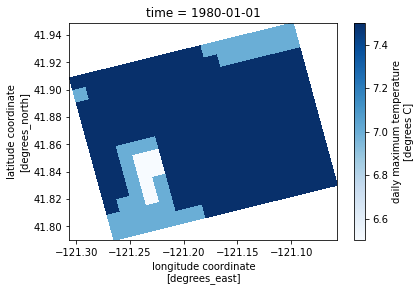

In [12]:
# **Plot tmax for the first day** to make sure we're looking at Clear Lake.
clearLake.isel(time=0).tmax.plot(x='lon', y='lat', cmap='Blues')

### We want to look at values only for August 1st tmax. We can do this with a combination of boolean (True/False) arrays and the .sel() method.

In [13]:
# An expression like this will produce a boolean DataArray, only True where the month is = 8 (August)

clearLake['time.month'] == 8

<xarray.DataArray 'month' (time: 14600)>
array([False, False, False, ..., False, False, False])
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2019-12-31

In [14]:
# We can combine these expressions with operators like & (and)

(clearLake['time.month'] == 8) & (clearLake['time.day'] == 1)

<xarray.DataArray (time: 14600)>
array([False, False, False, ..., False, False, False])
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2019-12-31

In [17]:
# And finally used them with an expression within .sel() to get values that only correspond with "True"
clearLake_august1 = clearLake.sel(time=( (clearLake['time.month'] == 8) & (clearLake['time.day'] == 1) ) )
clearLake

<xarray.Dataset>
Dimensions:                  (nv: 2, time: 14600, x: 17, y: 13)
Coordinates:
  * x                        (x) float32 -1667250.0 -1666250.0 ... -1651250.0
  * y                        (y) float32 151000.0 150000.0 ... 140000.0 139000.0
  * time                     (time) datetime64[ns] 1980-01-01 ... 2019-12-31
    lat                      (y, x) float32 41.905098 41.907482 ... 41.833397
    lon                      (y, x) float32 -121.298546 ... -121.06489
Dimensions without coordinates: nv
Data variables:
    lambert_conformal_conic  int16 -32767
    yearday                  (time) int16 0 1 2 3 4 5 ... 360 361 362 363 364
    time_bnds                (time, nv) datetime64[ns] 1980-01-01 ... 2020-01-01
    dayl                     (time, y, x) float32 ...
    prcp                     (time, y, x) float32 ...
    srad                     (time, y, x) float32 ...
    swe                      (time, y, x) float32 ...
    tmax                     (time, y, x) float32 ...
    tmin                     (time, y, x) float32 ...
    vp                       (time, y, x) float32 ...
Attributes:
    start_year:        1980
    source:            Daymet Software Version 3.0
    Version_software:  Daymet Software Version 3.0
    Version_data:      Daymet Data Version 3.0
    Conventions:       CF-1.6
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...
    title:             Daymet: Daily Surface Weather Data on a 1-km Grid for ...
    institution:       Oak Ridge National Laboratory Distributed Active Archi...
    end_year:          2019